## Concrete Compressive Strength Prediction

#### cement: a substance used for construction that hardens to other materials to bind them together.

#### slag: Mixture of metal oxides and silicon dioxide.

#### Flyash: coal combustion product that is composed of the particulates that are driven out of coal-fired boilers together with the flue gases.

#### Water: It is used to form a thick paste.

#### Superplasticizer:  used in making high-strength concrete.

#### Coaseseaggregate: prices of rocks obtain from ground deposits. 

#### fineaggregate: the size of aggregate small than 4.75mm.

#### age: Rate of gain of strength is faster to start with and the rate gets reduced with age.

#### csMPa: Measurement unit of concrete strength.

In [43]:
### importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
warnings.filterwarnings('ignore')

### importing scikit learn modules
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,RandomForestRegressor
from sklearn.svm import SVR,LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [44]:
### Loading dataset
data = pd.read_csv('./Concrete_Data.csv')
data.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cement            1030 non-null   float64
 1   slag              1030 non-null   float64
 2   flyash            1030 non-null   float64
 3   water             1030 non-null   float64
 4   superplasticizer  1030 non-null   float64
 5   coarseaggregate   1030 non-null   float64
 6   fineaggregate     1030 non-null   float64
 7   age               1030 non-null   int64  
 8   csMPa             1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [46]:
### Nulll value count
data.isnull().sum()

cement              0
slag                0
flyash              0
water               0
superplasticizer    0
coarseaggregate     0
fineaggregate       0
age                 0
csMPa               0
dtype: int64

In [47]:
#data = data.replace(0.0,np.nan)

In [48]:
#data.isnull().mean()*100

In [49]:
data.shape

(1030, 9)

## Exploratory data analysis

In [50]:
data.columns

Index(['cement', 'slag', 'flyash', 'water', 'superplasticizer',
       'coarseaggregate', 'fineaggregate', 'age', 'csMPa'],
      dtype='object')

In [51]:
iv_cols =['cement', 'slag', 'flyash', 'water', 'superplasticizer',
       'coarseaggregate', 'fineaggregate', 'age', ]

In [52]:
palette = itertools.cycle(sns.color_palette())

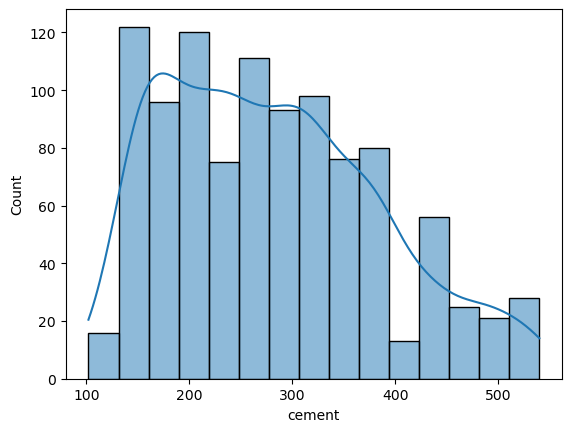

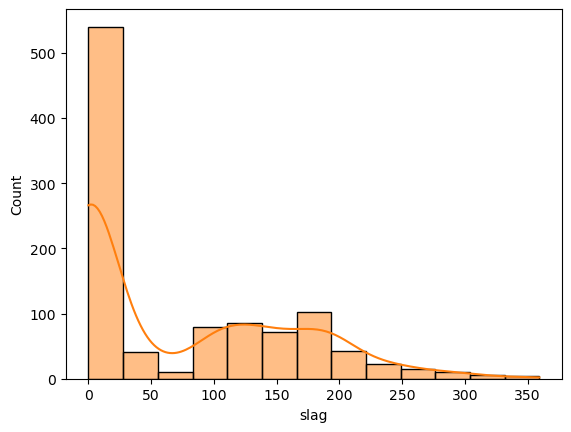

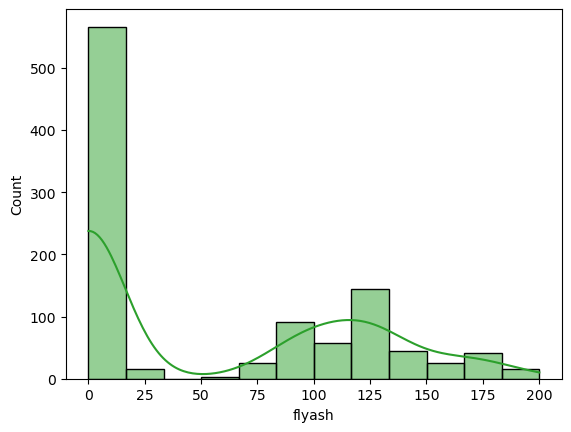

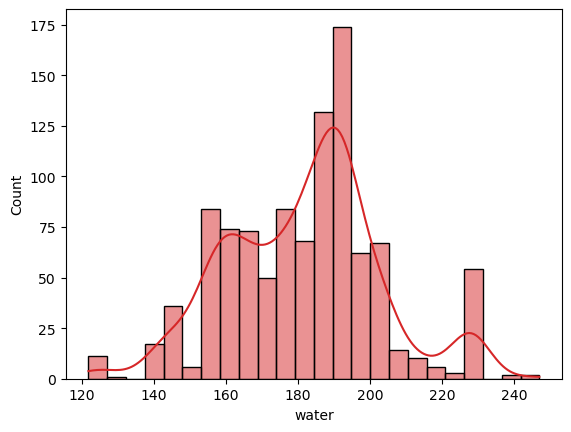

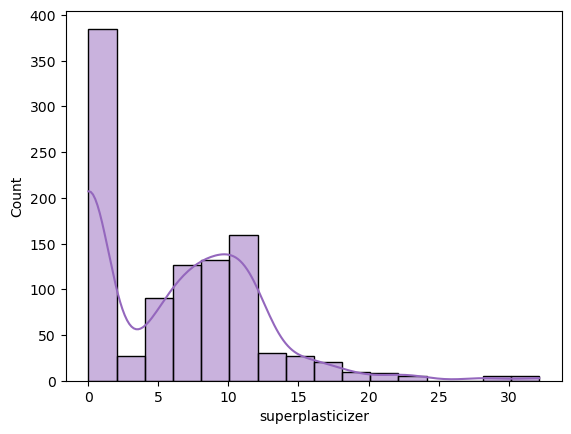

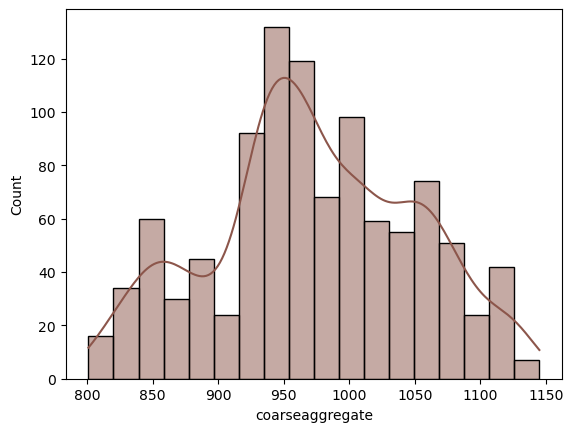

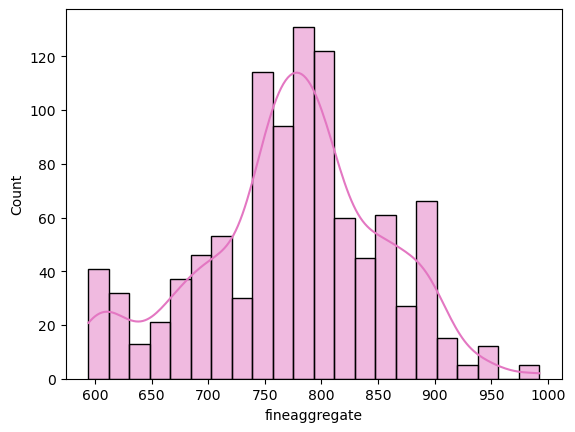

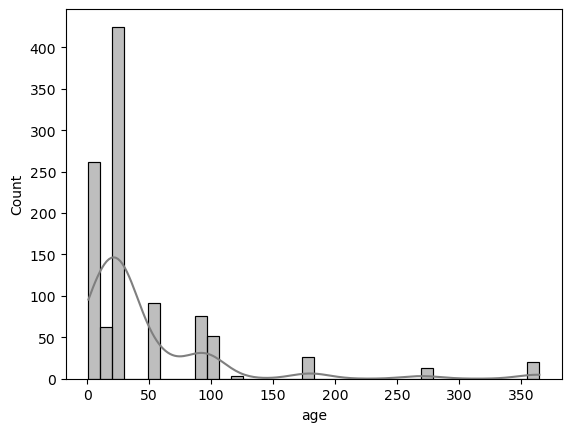

In [53]:
## histplot
for i in iv_cols:
    sns.histplot(data=data,x=data[i],kde=True,color=next(palette))
    plt.show()

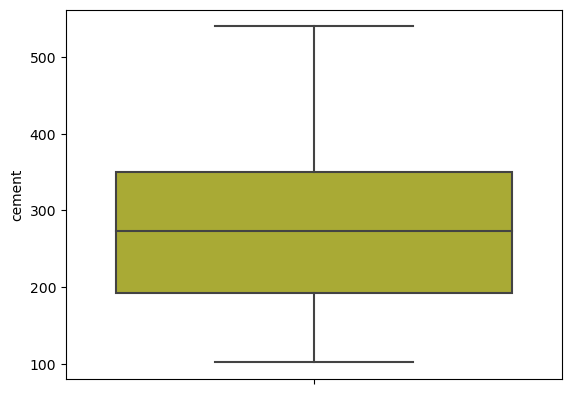

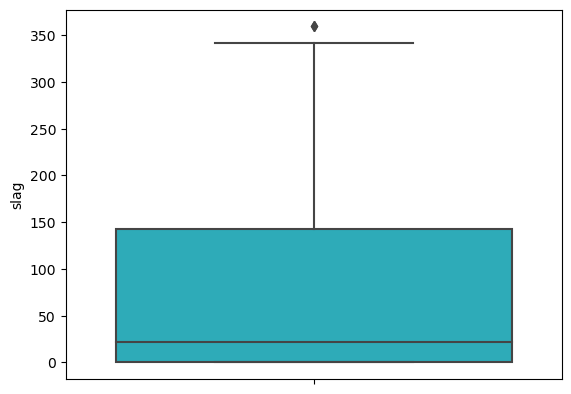

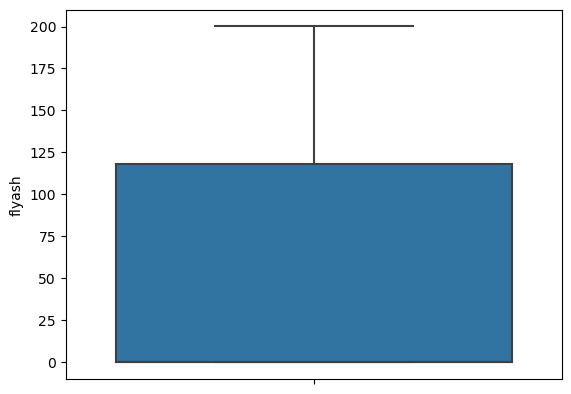

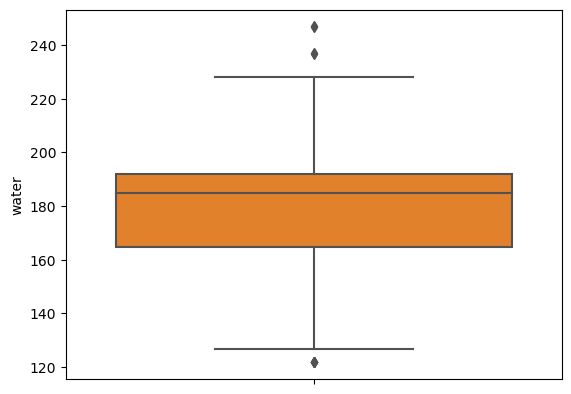

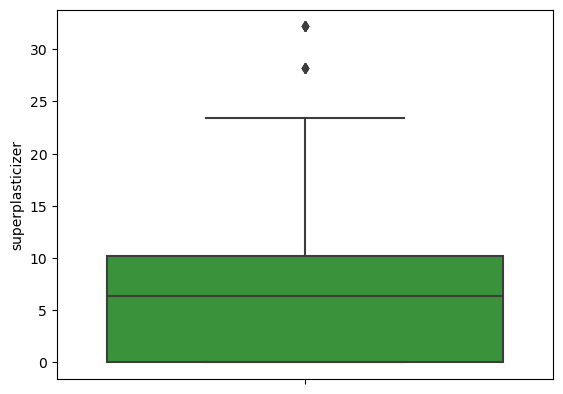

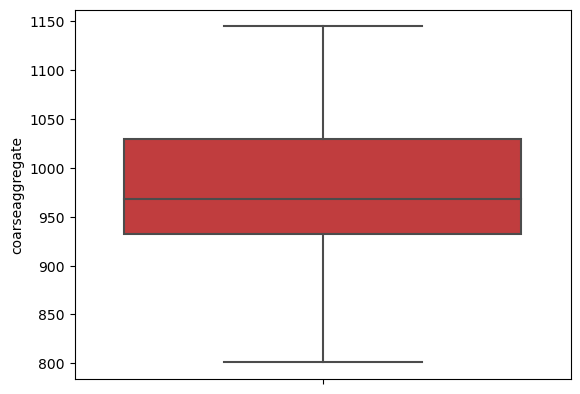

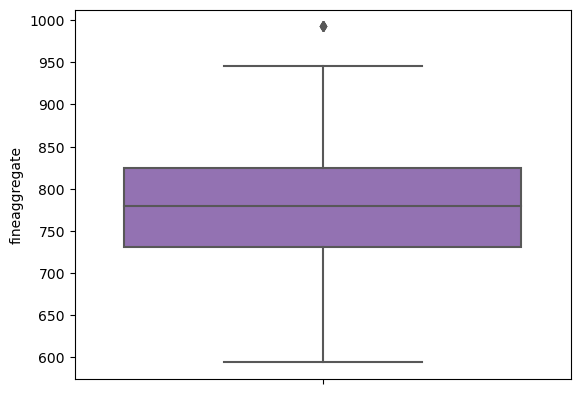

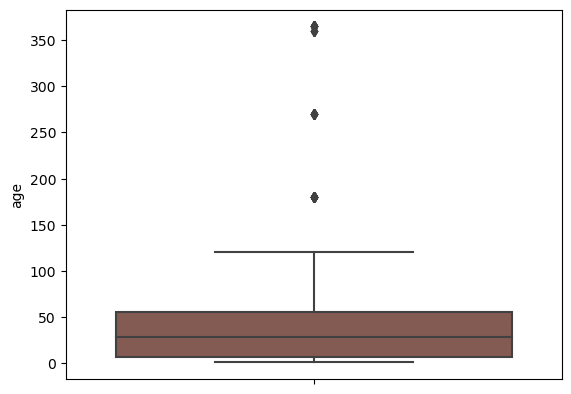

In [54]:
## Boxplot
for i in iv_cols:
    sns.boxplot(data=data,y=data[i],color=next(palette))
    plt.show()

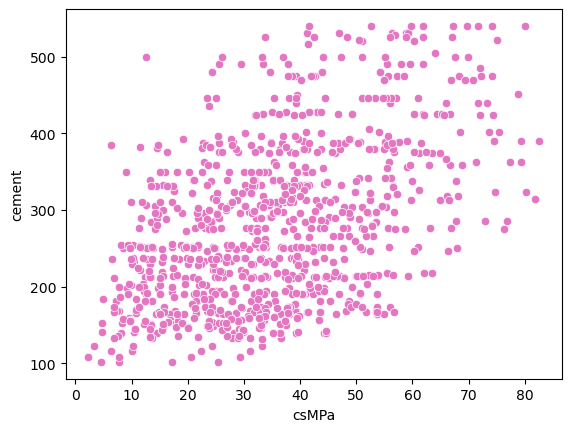

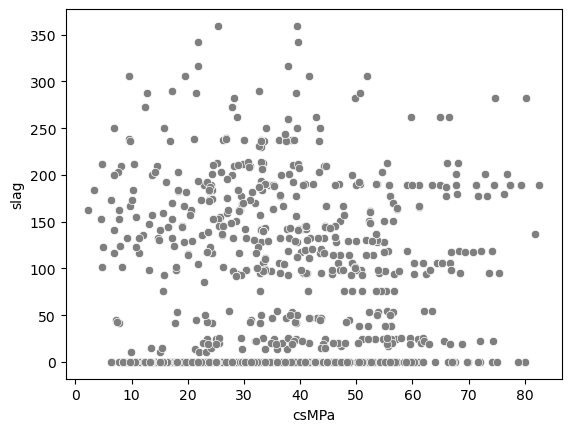

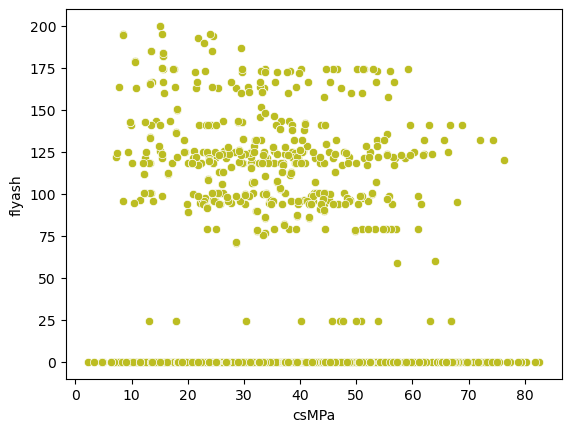

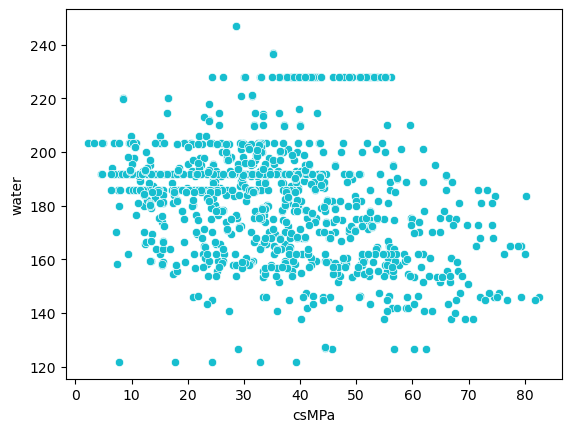

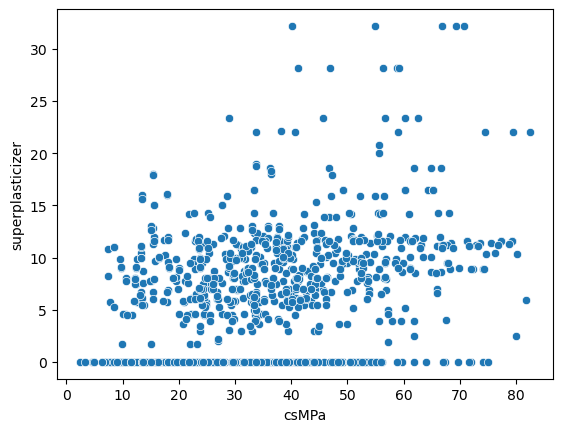

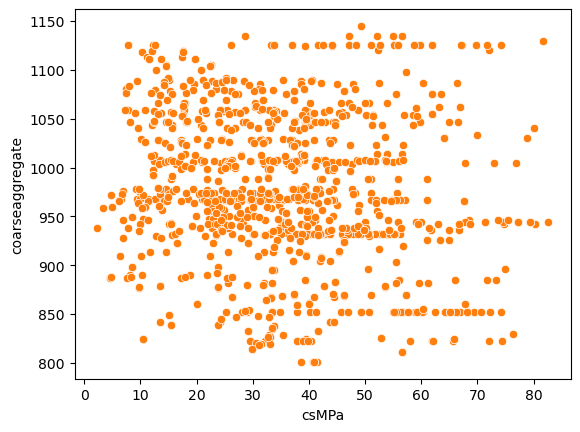

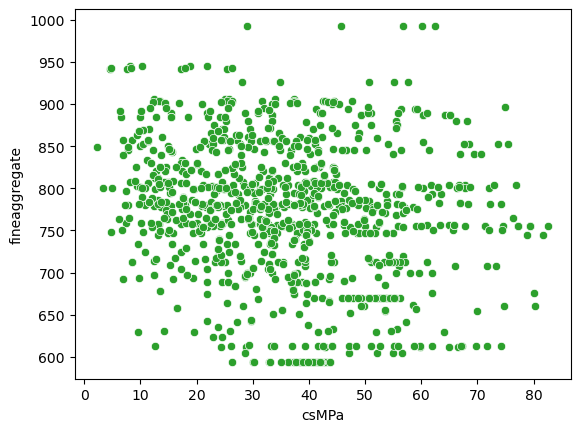

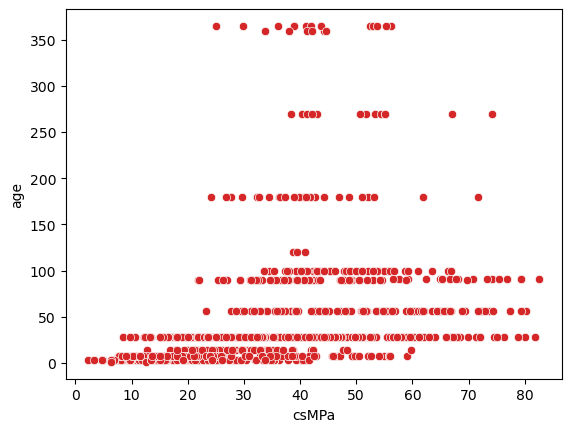

In [55]:
### Scatter plot
for i in iv_cols:
    sns.scatterplot(data=data,x='csMPa',y=data[i],color=next(palette))
    plt.show()

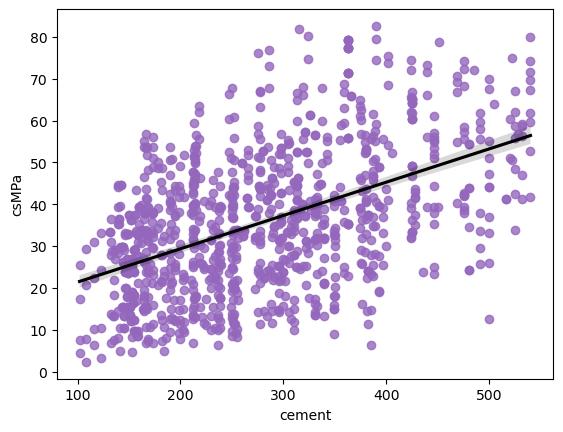

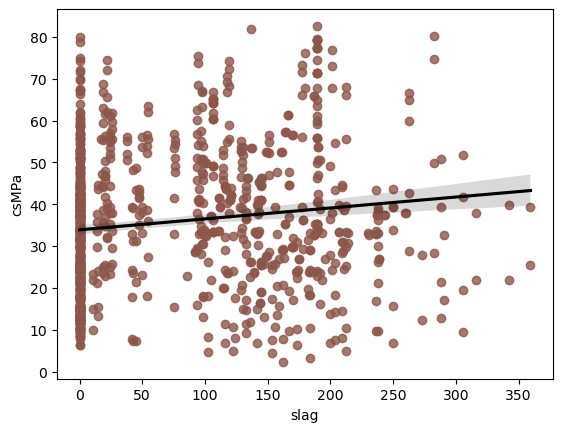

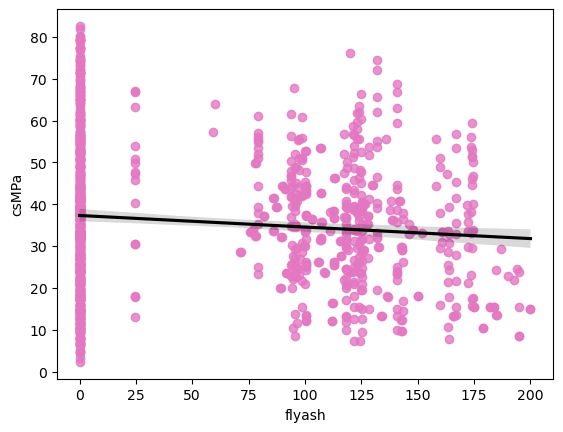

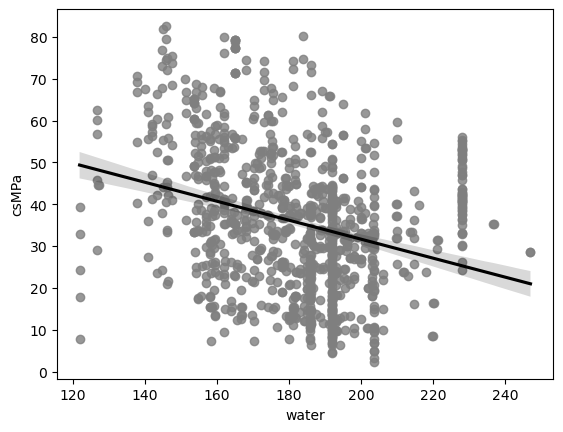

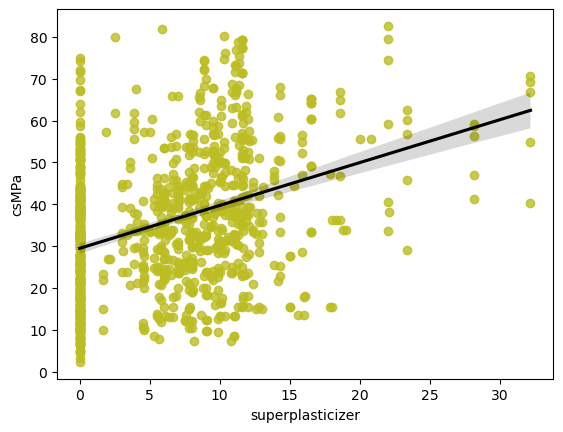

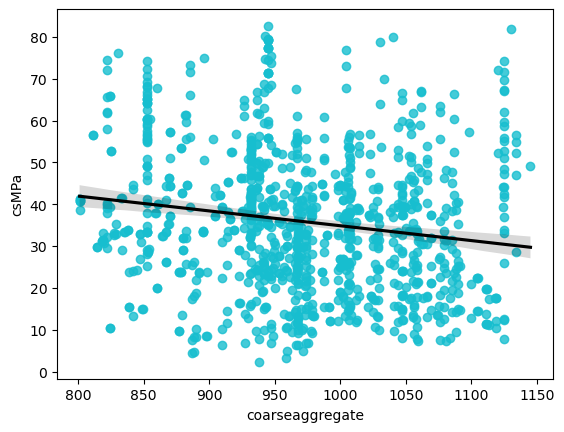

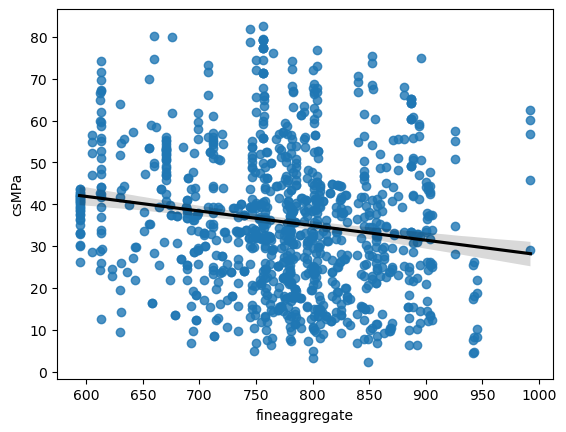

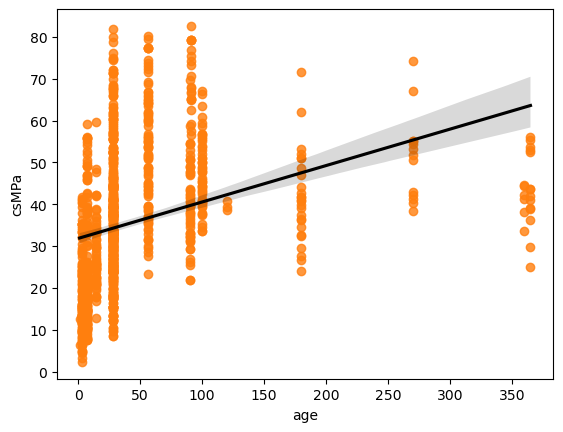

In [56]:
## Regplot
for i in iv_cols:
    sns.regplot(data=data,x=data[i],y='csMPa',color=next(palette),line_kws={"color":"black"})
    plt.show()

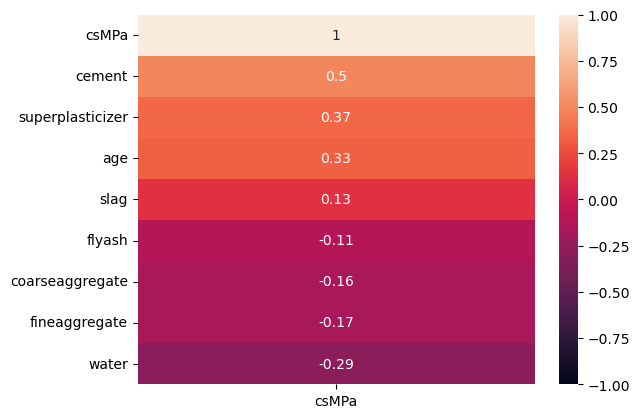

In [57]:
sns.heatmap(data.corr()[['csMPa']].sort_values(by='csMPa',ascending=False),vmax=1,vmin=-1,annot=True)
plt.show()

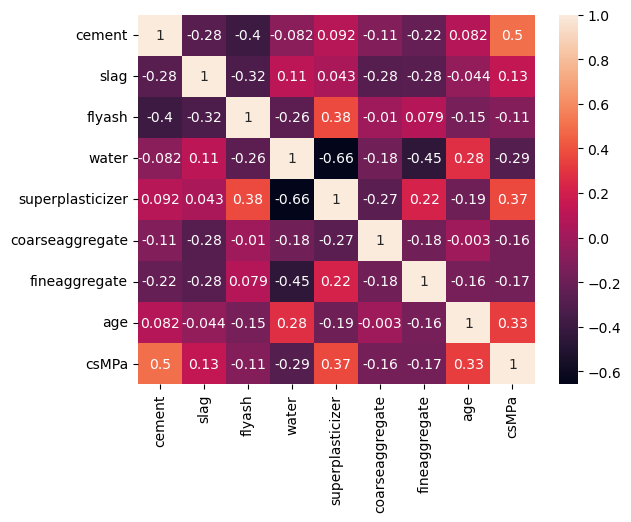

In [58]:
sns.heatmap(data.corr(),annot=True)
plt.show()

### Outlier treatment

In [59]:
## Setting outer limits
def outlier_limit(col):
    Q3,Q1 = np.nanpercentile(col,[75,25])
    IQR = Q3-Q1
    UL = Q3+1.5*IQR
    LL = Q1-1.5*IQR
    return UL,LL

In [60]:
for i in data.columns:
    UL,LL = outlier_limit(data[i])
    data[i] = np.where((data[i]>UL) | (data[i]<LL),np.nan,data[i])

In [61]:
data.isnull().sum()

cement               0
slag                 2
flyash               0
water                9
superplasticizer    10
coarseaggregate      0
fineaggregate        5
age                 59
csMPa                4
dtype: int64

In [62]:
data.dropna(inplace=True)


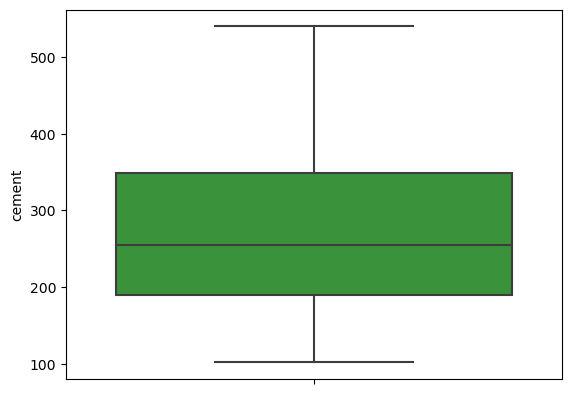

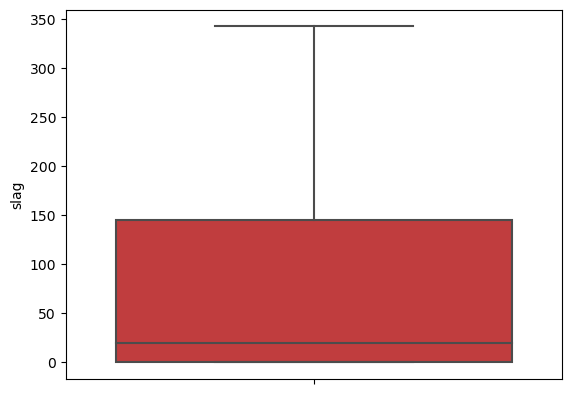

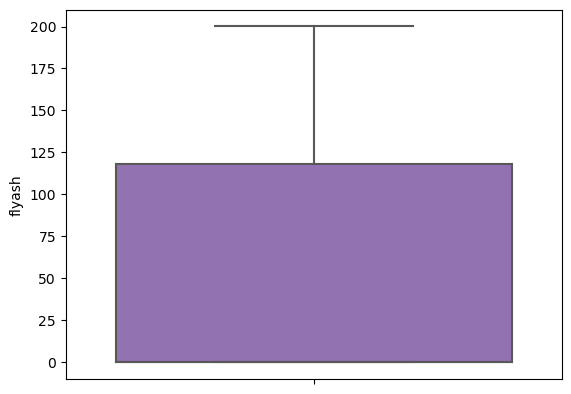

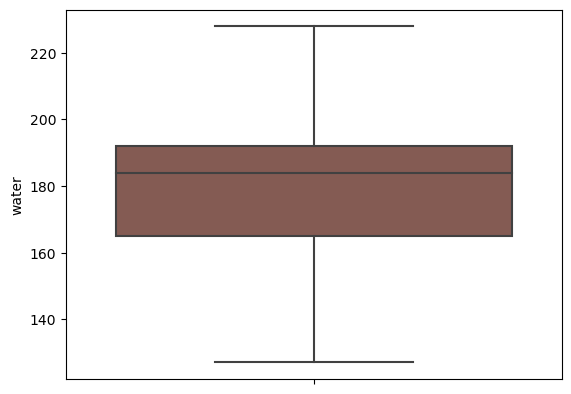

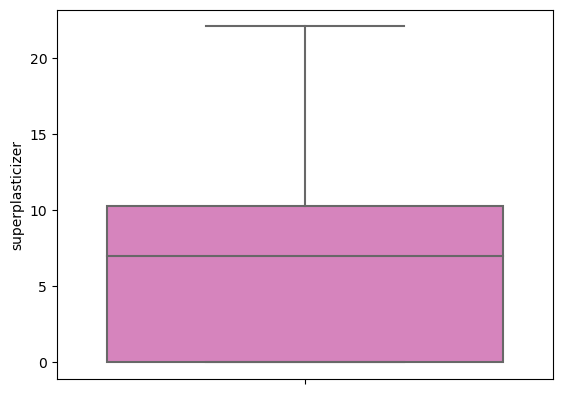

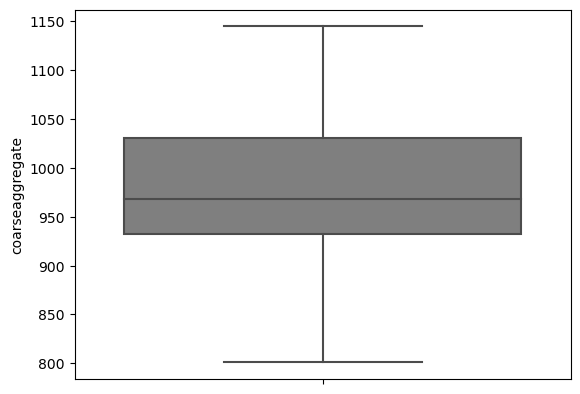

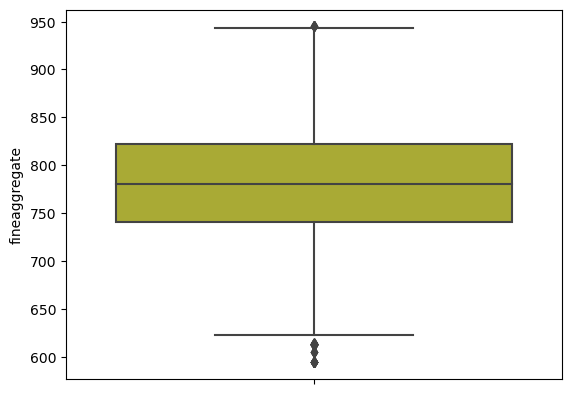

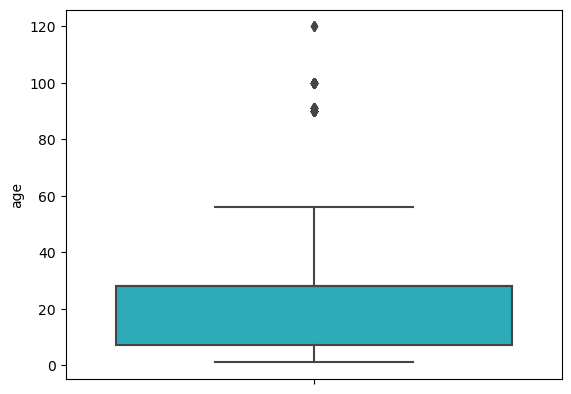

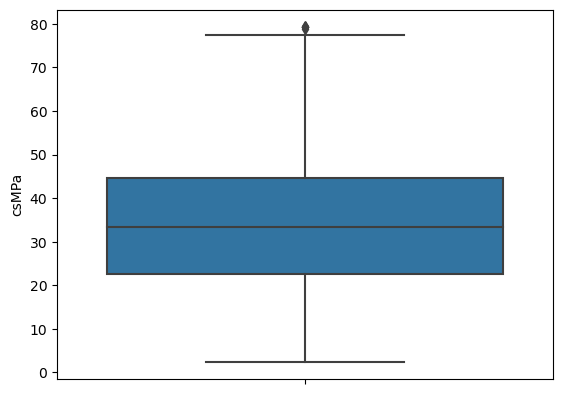

In [63]:
for i in data.columns:
    sns.boxplot(data=data,y=data[i],color=next(palette))
    plt.show()

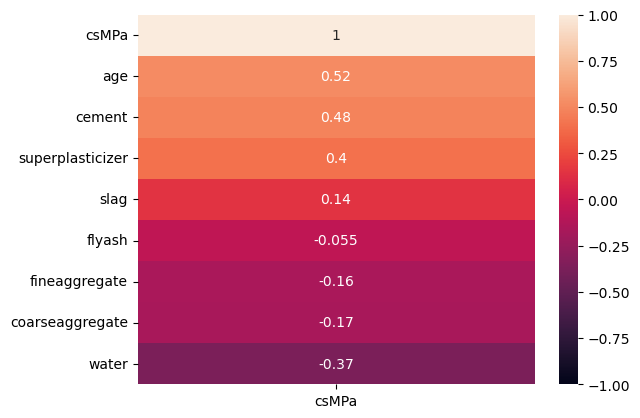

In [64]:
sns.heatmap(data.corr()[['csMPa']].sort_values(by='csMPa',ascending=False),vmax=1,vmin=-1,annot=True)
plt.show()

### Correlation checking positive values

In [65]:
pstv_pred = data.drop(columns=['flyash', 'water',
       'coarseaggregate', 'fineaggregate'])
pstv_pred.head()

,cement,slag,superplasticizer,age,csMPa
1,540.0,0.0,2.5,28.0,61.89
5,266.0,114.0,0.0,90.0,47.03
7,380.0,95.0,0.0,28.0,36.45
8,266.0,114.0,0.0,28.0,45.85
9,475.0,0.0,0.0,28.0,39.29


In [66]:
x = pstv_pred.iloc[:,:-1].values
y = pstv_pred.iloc[:,-1].values

In [67]:
sc =StandardScaler()

In [68]:
x =sc.fit_transform(x)

In [69]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,shuffle=True,random_state=78)

In [70]:
models = {"Linear Regression":LinearRegression(),
          "Ridge":Ridge(),
          "Lasso":Lasso(),
          "Linear SVR":LinearSVR(),
          "Decision Tree regressor":DecisionTreeRegressor(),
          "Gradient Boosting Regressor":GradientBoostingRegressor(),
          "AdaBoostingRegressor":AdaBoostRegressor(),
          "Random Forest Regressor":RandomForestRegressor(random_state=0)
    
}

In [71]:
for name,model in models.items():
    model.fit(x_train,y_train)
    print("Model trained with {}".format(name))
    training_score = model.score(x_train,y_train)*100
    testing_score = model.score(x_test,y_test)*100
    score = r2_score(y_test,model.predict(x_test))
    mae = mean_absolute_error(y_test,model.predict(x_test))
    mse = mean_squared_error(y_test,model.predict(x_test))
    rmse = np.sqrt(mse)
    
    print("Training Score",training_score)
    print("Testing Score",testing_score)
    print("r2_score",score)
    print("mae",mae)
    print("mse",mse)
    print("rmse",rmse)
    print("*"*100)

Model trained with Linear Regression
Training Score 71.71450413365994
Testing Score 75.11838746590878
r2_score 0.7511838746590878
mae 6.592356406338914
mse 76.14376465388074
rmse 8.72603945979393
****************************************************************************************************
Model trained with Ridge
Training Score 71.71433064739745
Testing Score 75.11231415755479
r2_score 0.7511231415755479
mae 6.594494733503287
mse 76.16235044936899
rmse 8.727104356507317
****************************************************************************************************
Model trained with Lasso
Training Score 69.92170105990793
Testing Score 72.59820946465298
r2_score 0.7259820946465299
mae 6.91592966228726
mse 83.85612012724825
rmse 9.157298735284781
****************************************************************************************************
Model trained with Linear SVR
Training Score 71.3010868518174
Testing Score 74.77213183019356
r2_score 0.7477213183019356
mae 6.5196

### Selecting AdaBoosting Regressor

In [72]:
ABR_model = AdaBoostRegressor().fit(x_train,y_train)
y_pred = ABR_model.predict(x_test)
score = r2_score(y_test,y_pred)
print("Score before hyper parameter tuning is {}".format(score))

Score before hyper parameter tuning is 0.7971222229834478


#### Boosting accuracy of the model by hyper parameter tuning

In [212]:
ABR = AdaBoostRegressor(random_state=78)

In [213]:
parameters ={'n_estimators':[900,910,920,940,990,1000],
             'learning_rate' : [0.8, 0.85,0.9,0.91,0.92,0.93]
}

In [214]:
grid_ABR = GridSearchCV(estimator=ABR,
    param_grid= parameters,
    n_jobs=-1,
    refit=True,
    cv=2,
    verbose=3)

In [215]:
grid_ABR.fit(x_train,y_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


GridSearchCV(cv=2, estimator=AdaBoostRegressor(random_state=78), n_jobs=-1,
             param_grid={'learning_rate': [0.8, 0.85, 0.9, 0.91, 0.92, 0.93],
                         'n_estimators': [900, 910, 920, 940, 990, 1000]},
             verbose=3)

In [216]:
grid_ABR.best_params_

{'learning_rate': 0.91, 'n_estimators': 910}

#### Fitting the model using the best parameters

In [217]:
best_parameter_model = AdaBoostRegressor(learning_rate= 0.91,
 n_estimators= 910)

In [218]:
best_parameter_model.fit(x_train,y_train)

AdaBoostRegressor(learning_rate=0.91, n_estimators=910)

In [219]:
y_pred = best_parameter_model.predict(x_test)

In [220]:
best_parameter_model.score(x_test,y_test)

0.7979558860542384

In [221]:
best_parameter_model.score(x_train,y_train)

0.801249359962063